In [1]:
pip install ucimlrepo numpy pandas matplotlib scikit-learn seaborn autograd torch tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    support2 = fetch_ucirepo(id=880)

    # data (as pandas dataframes)
    X = support2.data.features
    y = support2.data.targets

    # metadata
    print(support2.metadata)

    # variable information
    print(support2.variables)
except ConnectionError as e:
    import pandas as pd
    print("Unable to fetch dataset. Trying to load from local file.")
    support2 = pd.read_csv("data.csv")
    X = support2.iloc[:,:-3]
    y = support2.iloc[:,-3:]

Unable to fetch dataset. Trying to load from local file.


In [3]:
# support2.variables.to_csv("support2_codebook.csv", index=False)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.concat([X,y],axis=1)
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,ph,glucose,bun,urine,adlp,adls,adlsc,death,hospdead,sfdm2
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,NaN,...,7.459961,NaN,NaN,NaN,7.0,7.0,7.000000,0,0,NaN
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,NaN,...,7.250000,NaN,NaN,NaN,NaN,1.0,1.000000,1,1,<2 mo. follow-up
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,41094.0,NaN,...,7.459961,NaN,NaN,NaN,1.0,0.0,0.000000,1,0,<2 mo. follow-up
3,42.38498,female,Lung Cancer,Cancer,2,11.0,under $11k,0.0,3075.0,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,1,0,no(M2 and SIP pres)
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,26.0,50127.0,NaN,...,7.509766,NaN,NaN,NaN,NaN,2.0,2.000000,0,0,no(M2 and SIP pres)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,8.0,NaN,0.0,52870.0,34329.3125,...,7.459961,188.0,21.0,NaN,NaN,0.0,0.000000,0,0,NaN
9101,55.15399,female,Coma,Coma,1,11.0,NaN,41.0,35377.0,23558.5000,...,7.289062,190.0,49.0,0.0,NaN,0.0,0.000000,0,0,NaN
9102,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,0.0,46564.0,31409.0156,...,7.379883,189.0,60.0,3900.0,NaN,NaN,2.525391,0,0,NaN
9103,47.01999,male,MOSF w/Malig,ARF/MOSF,1,13.0,NaN,0.0,58439.0,NaN,...,7.469727,246.0,55.0,NaN,NaN,0.0,0.000000,1,1,<2 mo. follow-up


In [5]:
missed_target_data = data[data['sfdm2'].isnull()]
data = data.dropna(subset=['sfdm2'])

In [6]:
from tabulate import tabulate
def dataUnderstanding(data):
  # Number of the rows and columns
  rows, columns = data.shape
  print('-' * 50)
  print(f"Number of Rows:{rows} | Number of Columns:{columns}")
  print('-' * 50)
  print()

  # List of columns
  columns_df = pd.DataFrame(data.columns, columns=["Column Names"])
  print("List of Features in the dataset:")
  print(tabulate(columns_df, headers='keys', tablefmt='psql', showindex=False))
  print('-' * 50)
  print()

  # Print Data type
  print("Summarized basic information:\n")
  data.info()
  print('-' * 50)
  print()

  # printing all the numerical datatype columns
  numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
  print(f"Printing all the numerical columns --> {numerical_columns}")
  print()
  # printing all the object datatype columns
  object_columns = data.select_dtypes(include=['object']).columns.tolist()
  print(f"Printing all the Object columns --> {object_columns}")
  print('-' * 50)
  print()

  # finding the missing values
  print(f"Finding the number of missing values in all the columns -->\n")
  print(data.isna().sum())
  print('-' * 50)


dataUnderstanding(data)

--------------------------------------------------
Number of Rows:7705 | Number of Columns:45
--------------------------------------------------

List of Features in the dataset:
+----------------+
| Column Names   |
|----------------|
| age            |
| sex            |
| dzgroup        |
| dzclass        |
| num.co         |
| edu            |
| income         |
| scoma          |
| charges        |
| totcst         |
| totmcst        |
| avtisst        |
| race           |
| sps            |
| aps            |
| surv2m         |
| surv6m         |
| hday           |
| diabetes       |
| dementia       |
| ca             |
| prg2m          |
| prg6m          |
| dnr            |
| dnrday         |
| meanbp         |
| wblc           |
| hrt            |
| resp           |
| temp           |
| pafi           |
| alb            |
| bili           |
| crea           |
| sod            |
| ph             |
| glucose        |
| bun            |
| urine          |
| adlp           |
| ad

# Data Preprocessing

## Data Cleaning

### Missing Values

In [7]:
missing_value_table = data.isnull().sum()
missing_value_proportion = missing_value_table[missing_value_table>0].sort_values(ascending=False) / len(data)
for i in missing_value_proportion.index:
    print("{}: {:.2f}%".format(i,missing_value_proportion[i]*100), f'dtype={data[i].dtype}')

adlp: 60.78% dtype=float64
urine: 53.04% dtype=float64
glucose: 48.63% dtype=float64
bun: 47.33% dtype=float64
totmcst: 37.61% dtype=float64
alb: 36.07% dtype=float64
income: 28.70% dtype=object
bili: 27.90% dtype=float64
adls: 26.26% dtype=float64
pafi: 24.50% dtype=float64
ph: 24.04% dtype=float64
prg2m: 17.26% dtype=float64
prg6m: 17.09% dtype=float64
edu: 13.56% dtype=float64
totcst: 9.90% dtype=float64
wblc: 2.22% dtype=float64
charges: 1.83% dtype=float64
avtisst: 0.87% dtype=float64
crea: 0.65% dtype=float64
dnr: 0.39% dtype=object
dnrday: 0.39% dtype=float64
race: 0.38% dtype=object
scoma: 0.01% dtype=float64
sod: 0.01% dtype=float64
sps: 0.01% dtype=float64
aps: 0.01% dtype=float64
surv2m: 0.01% dtype=float64
temp: 0.01% dtype=float64
resp: 0.01% dtype=float64
hrt: 0.01% dtype=float64
surv6m: 0.01% dtype=float64
meanbp: 0.01% dtype=float64


In [8]:
X_pd = pd.DataFrame(X)
y_pd = pd.DataFrame(y)
X_pd.isnull().sum(), y_pd.isnull().sum()

(age            0
 sex            0
 dzgroup        0
 dzclass        0
 num.co         0
 edu         1634
 income      2982
 scoma          1
 charges      172
 totcst       888
 totmcst     3475
 avtisst       82
 race          42
 sps            1
 aps            1
 surv2m         1
 surv6m         1
 hday           0
 diabetes       0
 dementia       0
 ca             0
 prg2m       1649
 prg6m       1633
 dnr           30
 dnrday        30
 meanbp         1
 wblc         212
 hrt            1
 resp           1
 temp           1
 pafi        2325
 alb         3372
 bili        2601
 crea          67
 sod            1
 ph          2284
 glucose     4500
 bun         4352
 urine       4862
 adlp        5641
 adls        2867
 adlsc          0
 dtype: int64,
 death          0
 hospdead       0
 sfdm2       1400
 dtype: int64)

In [9]:
for i in data.columns:
  print(f'{i}:{data[i].dtype}')

age:float64
sex:object
dzgroup:object
dzclass:object
num.co:int64
edu:float64
income:object
scoma:float64
charges:float64
totcst:float64
totmcst:float64
avtisst:float64
race:object
sps:float64
aps:float64
surv2m:float64
surv6m:float64
hday:int64
diabetes:int64
dementia:int64
ca:object
prg2m:float64
prg6m:float64
dnr:object
dnrday:float64
meanbp:float64
wblc:float64
hrt:float64
resp:float64
temp:float64
pafi:float64
alb:float64
bili:float64
crea:float64
sod:float64
ph:float64
glucose:float64
bun:float64
urine:float64
adlp:float64
adls:float64
adlsc:float64
death:int64
hospdead:int64
sfdm2:object


In [10]:
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

def fill_missing_values_simplified(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing values in a DataFrame using KNNImputer for numerical columns
    and SimpleImputer (most frequent) for categorical columns.

    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing missing values.

    Returns:
    --------
    pd.DataFrame
        The DataFrame with missing values filled.
    """
    data_filled = data.copy()
    
    # Identify numerical and categorical columns
    numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

    # Impute numerical columns with KNNImputer
    if numerical_cols and data_filled[numerical_cols].isnull().sum().sum() > 0:
        knn_imputer = KNNImputer(n_neighbors=13,weights='distance')
        data_filled[numerical_cols] = knn_imputer.fit_transform(data_filled[numerical_cols])

    # Impute categorical columns with the most frequent value
    if categorical_cols and data_filled[categorical_cols].isnull().sum().sum() > 0:
        simple_imputer = SimpleImputer(strategy='most_frequent')
        data_filled[categorical_cols] = simple_imputer.fit_transform(data_filled[categorical_cols])

    return data_filled

# Create a copy to avoid modifying the original data in place
data_filled = data.copy()

# Loop through columns with missing values and apply the simplified filling logic
for col in missing_value_proportion.index:
    # Add a missing value indicator column before filling
    data_filled['missing_' + col] = data_filled[col].isnull().astype(float)

# Apply the simplified imputation to the whole dataframe
data = fill_missing_values_simplified(data_filled)


In [11]:
data.isnull().sum()

age               0
sex               0
dzgroup           0
dzclass           0
num.co            0
                 ..
missing_temp      0
missing_resp      0
missing_hrt       0
missing_surv6m    0
missing_meanbp    0
Length: 77, dtype: int64

In [12]:
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,missing_scoma,missing_sod,missing_sps,missing_aps,missing_surv2m,missing_temp,missing_resp,missing_hrt,missing_surv6m,missing_meanbp
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,$11-$25k,44.0,34496.0,90204.727559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,41094.0,19285.552491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,under $11k,0.0,3075.0,7220.971282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.800732,under $11k,26.0,50127.0,27862.323252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,93.01599,male,Coma,Coma,1.0,14.000000,under $11k,55.0,6884.0,12511.005442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9097,64.48499,female,Lung Cancer,Cancer,2.0,11.000000,$11-$25k,0.0,6830.0,4100.550800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9098,70.42297,male,ARF/MOSF w/Sepsis,ARF/MOSF,4.0,12.000000,under $11k,0.0,80504.0,56370.812500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9099,68.61597,female,COPD,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,2758.0,1847.376000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9103,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,under $11k,0.0,58439.0,30367.948037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Outlier Detection

In [13]:
def outlier_detection(data):
    """
    Detect outliers for numerical and categorical features.
    Returns a DataFrame with outlier flags (1=outlier, 0=normal) for each method.
    """
    results = data.copy()
    outlier_flags = pd.DataFrame(index=results.index)

    # Numerical: IQR method (threshold=3, typical for moderate outlier frequency)
    num_cols = results.select_dtypes(include=["number"]).columns
    # Exclude columns that start with 'missing_'
    num_cols = [col for col in num_cols if not col.startswith('missing_')]
    def iqr_detector(col, threshold=3):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return ((col < lower_bound) | (col > upper_bound)).astype(int)
    for col in num_cols:
        outlier_flags[f'iqr_{col}'] = iqr_detector(results[col])

    # Categorical: rare category (threshold=0.0005, i.e., <.1% frequency)
    cat_cols = results.select_dtypes(include=["object", "category"]).columns
    def category_outlier_detector(col, threshold=0.0005):
        freq = col.value_counts(normalize=True)
        rare_categories = freq[freq < threshold].index
        return col.isin(rare_categories).astype(int)
    for col in cat_cols:
        outlier_flags[f'cat_outlier_{col}'] = category_outlier_detector(results[col])

    return outlier_flags

In [14]:
demo = outlier_detection(data.copy())
demo.describe()

,iqr_age,iqr_num.co,iqr_edu,iqr_scoma,iqr_charges,iqr_totcst,iqr_totmcst,iqr_avtisst,iqr_sps,iqr_aps,...,iqr_death,iqr_hospdead,cat_outlier_sex,cat_outlier_dzgroup,cat_outlier_dzclass,cat_outlier_income,cat_outlier_race,cat_outlier_ca,cat_outlier_dnr,cat_outlier_sfdm2
count,7705.0,7705.0,7705.000000,7705.000000,7705.000000,7705.000000,7705.000000,7705.0,7705.000000,7705.000000,...,7705.0,7705.0,7705.0,7705.0,7705.0,7705.0,7705.0,7705.0,7705.0,7705.0
mean,0.0,0.0,0.007787,0.180532,0.049838,0.031538,0.033874,0.0,0.008696,0.000649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.087906,0.384655,0.217624,0.174778,0.180917,0.0,0.092850,0.025467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
count = 0
for row in demo.index:
    if demo.loc[row].sum() > 6:
        # print(f"Row {row} is an outlier in the following methods: {demo.loc[row][demo.loc[row] == 1].index.tolist()}")
        pass
    else:
        count += 1
count

7693

In [16]:
# delete outliers
def remove_outliers(data):
    """
    Remove outliers from the DataFrame.
    Returns a DataFrame with outliers removed.
    """
    crit = outlier_detection(data)
    for row in crit.index:
        if crit.loc[row].sum() > 6:
            data = data.drop(row)
    return data

data_no_outliers = remove_outliers(data.copy())

In [17]:
# recode the index
data_no_outliers.reset_index(drop=True, inplace=True)
data_no_outliers

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,missing_scoma,missing_sod,missing_sps,missing_aps,missing_surv2m,missing_temp,missing_resp,missing_hrt,missing_surv6m,missing_meanbp
0,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,$11-$25k,44.0,34496.0,90204.727559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,41094.0,19285.552491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,under $11k,0.0,3075.0,7220.971282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.800732,under $11k,26.0,50127.0,27862.323252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,93.01599,male,Coma,Coma,1.0,14.000000,under $11k,55.0,6884.0,12511.005442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,64.48499,female,Lung Cancer,Cancer,2.0,11.000000,$11-$25k,0.0,6830.0,4100.550800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7689,70.42297,male,ARF/MOSF w/Sepsis,ARF/MOSF,4.0,12.000000,under $11k,0.0,80504.0,56370.812500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7690,68.61597,female,COPD,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,2758.0,1847.376000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7691,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,under $11k,0.0,58439.0,30367.948037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Engineering

In [18]:
data = data_no_outliers
data["Age_Class"] = pd.cut(data["age"], bins=[0, 40, 65, 79, 130], labels=["Young Adult","Adult", "Senior", "Elderly"])
data["Age_Class"].value_counts()

Age_Class
Adult          3127
Senior         2791
Elderly        1066
Young Adult     709
Name: count, dtype: int64

In [19]:
data['Risk'] = data['surv2m'] * data['surv2m'] / (data['surv6m']+1e-3)
data['phy_Risk'] = data['prg2m'] * data['prg2m'] / (data['prg6m']+1e-3)
data['short_term_diff'] = data['surv2m'] / data['prg2m']
data['long_term_diff'] = data['surv6m'] / data['prg6m']
# sigmoid scaling, change into [0,1] range and indicate a probability of shouldering a risk for month, which in common sense, is related to sfdm2 or death
data['Risk'] = 1 / (1 + np.exp(-data['Risk']))
data['Risk'].describe()

count    7693.000000
mean        0.688118
std         0.067039
min         0.500000
25%         0.663082
50%         0.705526
75%         0.722829
max         0.930901
Name: Risk, dtype: float64

In [20]:
# costs are often right skewed, so we can use log transformation
data['charges_log'] = np.log(data['charges'] + 1e-3)  # Adding a small constant to avoid log(0)
data['totcst_log'] = np.log(data['totcst'] + 1e-3)  # Adding a small constant to avoid log(0)
data['totcst_log'] = 5*(data['totcst_log']-min(data['totcst_log'])) # shift the minimum value to 0 and increase sparseness
data['totmcst_log'] = np.log(data['totmcst'] + 1e-3)  # Adding a small constant to avoid log(0)
data['totmcst_log'] = 5*(data['totmcst_log']-min(data['totmcst_log'])) # shift the minimum value to 0 and increase sparseness
data[['charges_log', 'totcst_log', 'totmcst_log']].describe()

d:\Anaconda\envs\machinelearning\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,charges_log,totcst_log,totmcst_log
count,7693.000000,7693.000000,7691.000000
mean,10.189897,82.905321,82.086470
std,1.257193,6.923822,10.432682
min,7.063905,0.000000,0.000000
25%,9.220687,78.470467,78.291332
50%,10.154013,83.032432,82.967351
75%,11.083603,87.478579,87.244035
max,14.057159,101.331579,101.908678


In [21]:
# Vital Signs
# These are often important indicators of health status and can be used to predict outcomes.
data['low_BP'] = data['meanbp'] <= 65
data['high_HR'] = data['hrt'] >= 100
data['high_resp'] = data['resp'] >= 30
data['high_temp'] = data['temp'] >= 38.0
data['low_temp'] = data['temp'] <= 36.0
data[['low_BP', 'high_HR', 'high_resp', 'high_temp', 'low_temp']].describe()

,low_BP,high_HR,high_resp,high_temp,low_temp
count,7693,7693,7693,7693,7693
unique,2,2,2,2,2
top,False,True,False,False,False
freq,5450,4008,5904,5349,6194


In [22]:
# pafi is a measure of the severity of illness, often used in critical care settings.
data['ARDS_severity'] = data['pafi'].apply(lambda x: 'Normal' if x >=300 else ('Mild' if x >= 200 else ('Moderate' if x >= 100 else 'Severe')))
data['ARDS_severity'].value_counts()

ARDS_severity
Mild        3578
Moderate    2101
Normal      1615
Severe       399
Name: count, dtype: int64

In [23]:
# arterial ph
data['acidosis'] = data['ph'] < 7.35
data['alkalosis'] = data['ph'] > 7.45
data[['acidosis', 'alkalosis']].describe()

,acidosis,alkalosis
count,7693,7693
unique,2,2
top,False,False
freq,6628,5734


In [24]:
# albumin
data['albumin_low'] = data['alb'] < 3.5
data['albumin_high'] = data['alb'] > 5.0
data[['albumin_low', 'albumin_high']].describe()

,albumin_low,albumin_high
count,7693,7693
unique,2,2
top,True,False
freq,6444,7680


In [25]:
# Bilirubin is a measure of liver function, often used in critical care settings.
data['bili_high'] = data['bili'] > 2.0
data[['bili_high']].describe()

,bili_high
count,7693
unique,2
top,False
freq,5674


In [26]:
# Creatinine is a measure of kidney function, often used in critical care settings.
data['creatinine_high'] = data['crea'] > 2
data[['creatinine_high']].describe()

,creatinine_high
count,7693
unique,2
top,False
freq,5958


In [27]:
# blood urea nitrogen (BUN) is a measure of kidney function, often used in critical care settings.
data['bun_high'] = data['bun'] > 20
# creatinine ratio is a measure of kidney function, often used in critical care settings.
data['creatinine_ratio'] = data['crea'] / (data['bun']+1e-6)  # Adding a small constant to avoid division by zero
data[['bun_high']].describe(),data[['creatinine_ratio']].describe()

(       bun_high
 count      7693
 unique        2
 top        True
 freq       5932,
        creatinine_ratio
 count       7693.000000
 mean           0.058242
 std            0.047327
 min            0.002576
 25%            0.029712
 50%            0.045625
 75%            0.069947
 max            1.000000)

In [28]:
# urine output is a measure of kidney function, often used in critical care settings.
data['urine_output_low'] = data['urine'] < 500
data[['urine_output_low']].describe()

,urine_output_low
count,7693
unique,2
top,False
freq,7323


In [29]:
# glucose is a measure of blood sugar levels, often used in critical care settings.
data['glucose_high'] = data['glucose'] > 200
data[['glucose_high']].describe()

,glucose_high
count,7693
unique,2
top,False
freq,6834


In [30]:
# adl scores
# 1. disability level
data['disability_level'] = data['adlsc'] <4
# 2. cognitive issues that leads to over optimism
data['cognitive_optimism'] = data['adlp']-data['adls']
# scaling to [0,1] range, showcasing a probability of cognitive optimism
data['cognitive_optimism'] = 1 / (1 + np.exp(-data['cognitive_optimism']))
data[['disability_level']].describe(), data[['cognitive_optimism']].describe()

(       disability_level
 count              7693
 unique                2
 top                True
 freq               6336,
        cognitive_optimism
 count         7693.000000
 mean             0.491223
 std              0.285864
 min              0.000911
 25%              0.268941
 50%              0.500000
 75%              0.731059
 max              0.999089)

In [31]:
data.columns

Index(['age', 'sex', 'dzgroup', 'dzclass', 'num.co', 'edu', 'income', 'scoma',
       'charges', 'totcst',
       ...
       'albumin_low', 'albumin_high', 'bili_high', 'creatinine_high',
       'bun_high', 'creatinine_ratio', 'urine_output_low', 'glucose_high',
       'disability_level', 'cognitive_optimism'],
      dtype='object', length=103)

In [32]:
# Organ Failures
# Each organ failure indicator is boolean, so sum them to count organ failures per row
data['organ_failure'] = (
	data['low_BP'].astype(int) +
	data['creatinine_high'].astype(int) +
	data['urine_output_low'].astype(int) +
	data['acidosis'].astype(int)
)
data['organ_failure'] =  1.5 / (1 + np.exp(-data['organ_failure'])) - 0.5*1.5
data['organ_failure'].describe()

count    7693.000000
mean        0.207954
std         0.236601
min         0.000000
25%         0.000000
50%         0.000000
75%         0.346588
max         0.723021
Name: organ_failure, dtype: float64

In [33]:
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,albumin_high,bili_high,creatinine_high,bun_high,creatinine_ratio,urine_output_low,glucose_high,disability_level,cognitive_optimism,organ_failure
0,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,$11-$25k,44.0,34496.0,90204.727559,...,False,True,True,True,0.146685,False,False,True,0.543491,0.678861
1,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,41094.0,19285.552491,...,False,True,False,True,0.059236,False,False,True,0.731059,0.000000
2,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,under $11k,0.0,3075.0,7220.971282,...,False,False,False,True,0.021165,False,False,True,0.500000,0.000000
3,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.800732,under $11k,26.0,50127.0,27862.323252,...,False,True,False,True,0.019566,False,False,True,0.312273,0.346588
4,93.01599,male,Coma,Coma,1.0,14.000000,under $11k,55.0,6884.0,12511.005442,...,False,True,False,True,0.022459,False,False,True,0.821172,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,64.48499,female,Lung Cancer,Cancer,2.0,11.000000,$11-$25k,0.0,6830.0,4100.550800,...,False,False,False,True,0.028813,False,True,True,0.356044,0.346588
7689,70.42297,male,ARF/MOSF w/Sepsis,ARF/MOSF,4.0,12.000000,under $11k,0.0,80504.0,56370.812500,...,False,True,False,True,0.054543,False,False,True,0.576799,0.000000
7690,68.61597,female,COPD,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,2758.0,1847.376000,...,False,False,False,False,0.047055,False,False,True,0.084368,0.000000
7691,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,under $11k,0.0,58439.0,30367.948037,...,False,False,True,True,0.063636,False,True,True,0.844227,0.346588


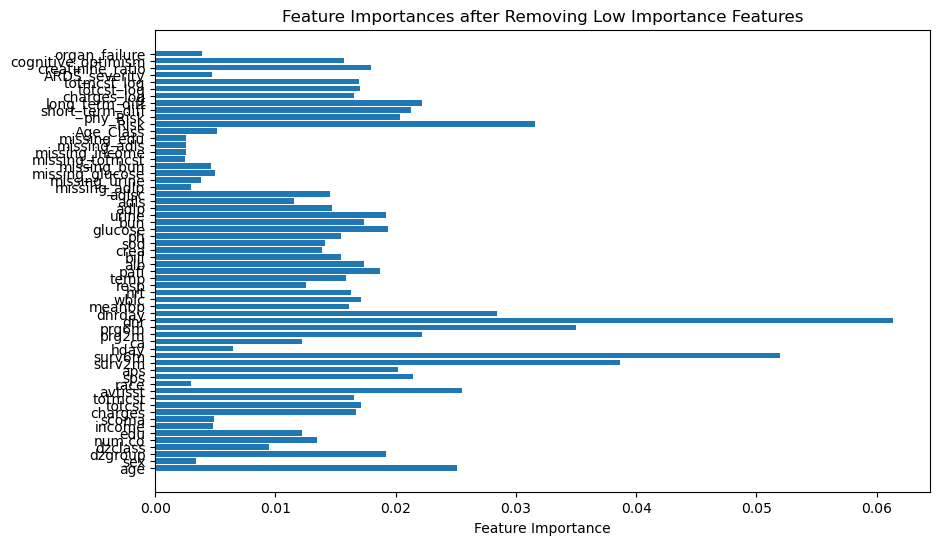

Number of features after removing low importance features: 60


In [34]:
# delete columns with low feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
def delete_low_importance_features(data, target_cols, threshold=0.01):
    """
    Delete columns with low feature importance based on Random Forest Classifier.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing features and target.
    target_cols : list
        The names of the target columns.
    threshold : float
        The minimum feature importance value to retain a feature.
        
    Returns:
    --------
    pd.DataFrame
        The DataFrame with low importance features removed.
    """
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X = data.drop(columns=target_cols)
    y = data[target_cols[0]]  # Use the first target column for feature importance

    # Encode categorical columns
    X_encoded = X.copy()
    cat_cols = X_encoded.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        X_encoded[cat_cols] = oe.fit_transform(X_encoded[cat_cols])

    # Replace inf/-inf with np.nan, then fill np.nan with column median
    X_encoded = X_encoded.replace([np.inf, -np.inf], np.nan)
    X_encoded = X_encoded.fillna(X_encoded.median(numeric_only=True))

    # Fit Random Forest Classifier
    model = RandomForestClassifier(n_estimators=500,criterion='entropy',random_state=42)
    model.fit(X_encoded, y)

    # Get feature importances
    importances = model.feature_importances_

    # Select features above the threshold
    selected_features = X_encoded.columns[importances > threshold]
    
    return data[selected_features.tolist() + target_cols], model.feature_importances_
# Only drop columns that exist in the DataFrame
target_cols = [col for col in ['death', 'sfdm2', 'hospdead'] if col in data_no_outliers.columns]
data_no_low_importance, importance = delete_low_importance_features(data_no_outliers, target_cols=target_cols, threshold=0.0025)

# plot feature importances for selected features only
selected_features = data_no_low_importance.drop(columns=['death']).columns

# Only drop columns that exist in the DataFrame for original_features
original_features = data_no_outliers.drop(columns=target_cols).columns

# Get importances for selected_features by matching their positions in original_features
selected_importances = [importance[original_features.get_loc(col)] for col in selected_features if col in original_features]

# Ensure selected_features and selected_importances have the same length
selected_features_plot = [col for col in selected_features if col in original_features]

plt.figure(figsize=(10, 6))
plt.barh(selected_features_plot, selected_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances after Removing Low Importance Features')
plt.show()
print(f"Number of features after removing low importance features: {len(selected_features_plot)}")

In [35]:
cat_cols = data_no_low_importance.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr', 'Age_Class',
       'ARDS_severity', 'sfdm2'],
      dtype='object')

In [36]:
dataUnderstanding(data_no_low_importance)

--------------------------------------------------
Number of Rows:7693 | Number of Columns:63
--------------------------------------------------

List of Features in the dataset:
+--------------------+
| Column Names       |
|--------------------|
| age                |
| sex                |
| dzgroup            |
| dzclass            |
| num.co             |
| edu                |
| income             |
| scoma              |
| charges            |
| totcst             |
| totmcst            |
| avtisst            |
| race               |
| sps                |
| aps                |
| surv2m             |
| surv6m             |
| hday               |
| ca                 |
| prg2m              |
| prg6m              |
| dnr                |
| dnrday             |
| meanbp             |
| wblc               |
| hrt                |
| resp               |
| temp               |
| pafi               |
| alb                |
| bili               |
| crea               |
| sod           

In [37]:
# Replace inf/-inf with np.nan before imputation
data_no_low_importance = data_no_low_importance.replace([np.inf, -np.inf], [1e6,1e-6])
data_no_low_importance = fill_missing_values_simplified(data_no_low_importance)
data_no_low_importance.isnull().sum()

age                   0
sex                   0
dzgroup               0
dzclass               0
num.co                0
                     ..
cognitive_optimism    0
organ_failure         0
death                 0
sfdm2                 0
hospdead              0
Length: 63, dtype: int64

In [38]:
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder
NominalEncoder_list = ['dzgroup', 'dzclass','ca', 'dnr','sex','race','Age_Class']
map_information = {'nominal':{},'ordinal':{}}
# check the number of unique values in each categorical column
for col in cat_cols:
    print(f"Number of unique values in {col}: {data_no_low_importance[col].nunique()}")

Number of unique values in sex: 2
Number of unique values in dzgroup: 8
Number of unique values in dzclass: 4
Number of unique values in income: 4
Number of unique values in race: 5
Number of unique values in ca: 3
Number of unique values in dnr: 3
Number of unique values in Age_Class: 4
Number of unique values in ARDS_severity: 4
Number of unique values in sfdm2: 5


In [39]:
# Ensure data_no_low_importance is defined
if 'data_no_low_importance' not in globals():
    # Only drop columns that exist in the DataFrame
    target_cols = [col for col in ['death', 'sfdm2', 'hospdead'] if col in data_no_outliers.columns]
    data_no_low_importance, importance = delete_low_importance_features(data_no_outliers, target_cols=target_cols, threshold=0.005)

# encode nominal encoder list as onehot encoder
for col in NominalEncoder_list:
    if col in data_no_low_importance.columns:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_col = ohe.fit_transform(data_no_low_importance[[col]])
        encoded_col_df = pd.DataFrame(encoded_col, columns=[f"{col}_{i}" for i in range(encoded_col.shape[1])], index=data_no_low_importance.index)
        data_no_low_importance = pd.concat([data_no_low_importance, encoded_col_df], axis=1)
        data_no_low_importance.drop(columns=[col], inplace=True)
        # record the mapping information
        map_information['nominal'][col] = ohe.categories_[0].tolist()
map_information

{'nominal': {'dzgroup': ['ARF/MOSF w/Sepsis',
   'CHF',
   'COPD',
   'Cirrhosis',
   'Colon Cancer',
   'Coma',
   'Lung Cancer',
   'MOSF w/Malig'],
  'dzclass': ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Cancer', 'Coma'],
  'ca': ['metastatic', 'no', 'yes'],
  'dnr': ['dnr after sadm', 'dnr before sadm', 'no dnr'],
  'sex': ['female', 'male'],
  'race': ['asian', 'black', 'hispanic', 'other', 'white'],
  'Age_Class': ['Adult', 'Elderly', 'Senior', 'Young Adult']},
 'ordinal': {}}

In [40]:
# encode ordinal encoder list and numeric columns
for col in cat_cols:
    # Skip columns that have been one-hot encoded and dropped, or are not present
    if col in NominalEncoder_list or col not in data_no_low_importance.columns:
        continue
    if data_no_low_importance[col].nunique() <= 30 and col!="scoma":  # Ordinal encoding for categorical columns (all with <= 30 unique values after manual check)
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        data_no_low_importance[col] = oe.fit_transform(data_no_low_importance[[col]])
        # record the mapping information as a dictionary: number value -> original value
        map_information['ordinal'][col] = {i: v for i, v in enumerate(oe.categories_[0])}
    else:
        data_no_low_importance[col] = data_no_low_importance[col].astype(float)  # Convert to float since mostly stated as float in the codebook
print(map_information)
# Only show columns that still exist
remaining_cat_cols = [col for col in cat_cols if col in data_no_low_importance.columns]
data_no_low_importance[remaining_cat_cols]

{'nominal': {'dzgroup': ['ARF/MOSF w/Sepsis', 'CHF', 'COPD', 'Cirrhosis', 'Colon Cancer', 'Coma', 'Lung Cancer', 'MOSF w/Malig'], 'dzclass': ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Cancer', 'Coma'], 'ca': ['metastatic', 'no', 'yes'], 'dnr': ['dnr after sadm', 'dnr before sadm', 'no dnr'], 'sex': ['female', 'male'], 'race': ['asian', 'black', 'hispanic', 'other', 'white'], 'Age_Class': ['Adult', 'Elderly', 'Senior', 'Young Adult']}, 'ordinal': {'income': {0: '$11-$25k', 1: '$25-$50k', 2: '>$50k', 3: 'under $11k'}, 'ARDS_severity': {0: 'Mild', 1: 'Moderate', 2: 'Normal', 3: 'Severe'}, 'sfdm2': {0: '<2 mo. follow-up', 1: 'Coma or Intub', 2: 'SIP>=30', 3: 'adl>=4 (>=5 if sur)', 4: 'no(M2 and SIP pres)'}}}


,income,ARDS_severity,sfdm2
0,0.0,3.0,0.0
1,3.0,0.0,0.0
2,3.0,0.0,4.0
3,3.0,1.0,4.0
4,3.0,0.0,0.0
...,...,...,...
7688,0.0,1.0,4.0
7689,3.0,0.0,0.0
7690,3.0,1.0,4.0
7691,3.0,2.0,0.0


# Data Visualization

In [41]:
df=data_no_low_importance
# use LDA to pick out important features
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.decomposition import SparsePCA

# Identify the correct target column for LDA
target_col = df['sfdm2']

# Prepare X and y for LDA
df = df.drop(columns=['sfdm2'])
X_lda_input = df.select_dtypes('number').copy()
y_lda = target_col

# LDA: n_components must be <= min(n_features, n_classes - 1)
n_classes = len(np.unique(y_lda))
n_features = X_lda_input.shape[1]
max_components = min(n_features, n_classes - 1)
lda = LDA(solver='svd',n_components=max_components)
X_lda = lda.fit_transform(X_lda_input, y_lda)

# Kernel PCA
kpca = KernelPCA(n_components=5, kernel='rbf')
# Kernel PCA
X_kpca = kpca.fit_transform(X_lda_input)

# FastICA
fastica = FastICA(n_components=5, random_state=42)
X_fastica = fastica.fit_transform(X_lda_input)
X_fastica = pd.DataFrame(X_fastica)

# NMF (requires non-negative data)
X_nmf_input = X_lda_input.clip(lower=0)  # Ensure non-negativity
nmf = NMF(n_components=5, init='random', random_state=42, max_iter=500)
X_nmf = nmf.fit_transform(X_nmf_input)
X_nmf = pd.DataFrame(X_nmf)

# Sparse PCA
spca = SparsePCA(n_components=5, random_state=42)
X_spca = spca.fit_transform(X_lda_input)
X_spca = pd.DataFrame(X_spca)

X_kpca = pd.DataFrame(X_kpca)
# Convert X_lda to DataFrame before concatenation
X_lda_df = pd.DataFrame(X_lda)
lda_df = pd.concat([X_lda_df, X_kpca, X_fastica, X_nmf, X_spca], axis=1)
lda_df

,0,1,2,3,0,1,2,3,4,0,...,0,1,2,3,4,0,1,2,3,4
0,1.464348,0.774992,0.186875,-0.133243,-0.000184,-0.009080,-0.015617,-0.006369,0.002539,-0.048816,...,1334.216181,1.879825,0.000000,43.696078,10.154442,1.335554e+06,30865.187066,227710.646890,71271.791107,19843.176756
1,-0.950023,0.572166,-0.651984,-1.218171,-0.000184,-0.004761,-0.002745,-0.003777,-0.002753,-0.136648,...,0.000000,7.477672,0.000000,10.067216,0.023246,-4.599963e+04,-25225.497250,4678.098180,-6869.393326,40.031916
2,-0.925876,0.954009,0.605192,-0.042805,-0.000184,-0.025625,-0.000662,0.000013,0.002884,-0.136813,...,0.000000,0.078892,0.000000,4.469034,0.007192,-4.554457e+04,-65380.911424,5250.818030,-1048.166457,-1254.540257
3,-1.551203,-0.541643,0.375283,1.160681,-0.000184,0.001103,-0.159846,-0.007363,0.019556,-0.134975,...,0.000000,8.792560,0.000000,14.843245,0.023780,-4.617765e+04,-11414.545701,4533.166623,-832.428167,225.715656
4,2.221889,0.408480,0.984250,1.417757,-0.000184,0.015804,-0.001972,-0.001339,0.003363,-0.067240,...,1334.631442,0.533881,0.973134,7.201975,8.705917,1.336556e+06,-39031.865756,228223.512782,6060.043118,-279.220051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,-2.137345,0.926398,0.218291,0.848358,-0.000184,0.000428,-0.001999,0.000350,0.003237,-0.138108,...,0.000000,1.213472,0.000000,1.943382,0.042023,-4.552903e+04,-65216.192197,5201.483803,-8301.504495,77.100025
7689,0.306741,-0.668208,-0.513480,-0.375465,-0.000184,0.000995,-0.001497,0.000402,0.002628,-0.129473,...,0.000000,13.272124,0.000000,30.480042,0.027689,-4.676539e+04,34522.371915,4046.385331,18555.693258,1345.759644
7690,-1.722227,1.058928,0.189108,0.006914,-0.000184,0.002413,-0.000827,0.001128,0.001069,-0.138354,...,0.000000,0.453171,0.000000,1.051566,0.008862,-4.547244e+04,-69876.411944,5264.219307,-8255.221731,-741.490568
7691,2.968541,1.309727,0.259652,-0.228333,-0.000184,0.002530,-0.000730,0.001171,0.000924,-0.134563,...,0.000000,10.038499,0.014796,18.639475,0.000000,-4.632124e+04,398.943444,4405.556943,3555.113162,-5473.243146


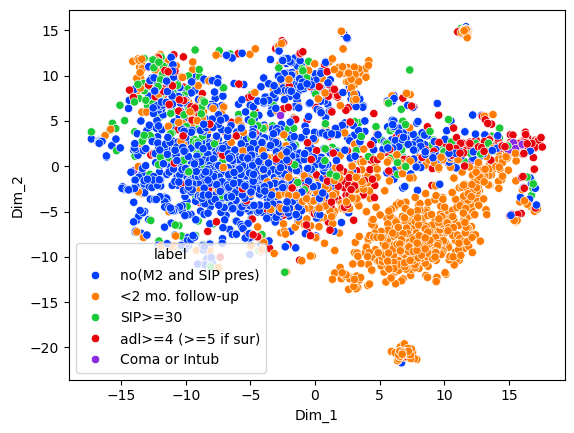

In [53]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# 2D t-SNE plot
indexes = df[5000:].index
data_1000 = lda_df.iloc[indexes]
labels_1000 = target_col.iloc[indexes]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_1000)
tsne = TSNE(n_components=2, perplexity=170, random_state=3407, max_iter=10000)
tsne_result = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_result, columns=["Dim_1", "Dim_2"])
# Convert float labels to int for mapping
label_map = map_information['ordinal']['sfdm2']
tsne_df["label"] = [label_map.get(int(l), str(l)) for l in labels_1000.values]

sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label', palette="bright")
plt.show()

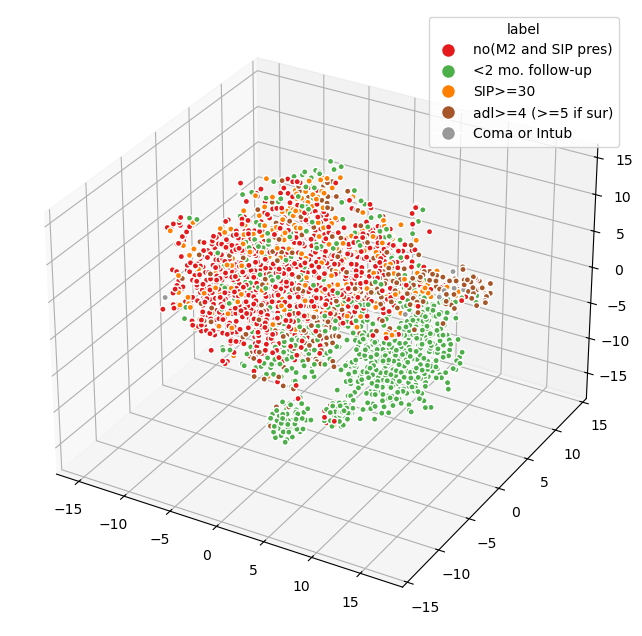

In [55]:
# 3D t-SNE plot
tsne_3D = TSNE(n_components=3, perplexity=170, random_state=3407, max_iter=10000)
tsne_result_3D = tsne_3D.fit_transform(scaled_data)
tsne_df_3D = pd.DataFrame(data=tsne_result_3D, columns=["Dim_1", "Dim_2", "Dim_3"])
# Convert float labels to int for mapping
tsne_df_3D["label"] = [label_map.get(int(l), str(l)) for l in labels_1000.values]

# Map string labels to integers for coloring
unique_labels = tsne_df_3D["label"].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
tsne_df_3D["label_int"] = tsne_df_3D["label"].map(label_to_int)

from matplotlib.colors import ListedColormap, BoundaryNorm

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a ListedColormap for consistent color mapping
cmap = plt.get_cmap("Set1", len(unique_labels))
norm = BoundaryNorm(range(len(unique_labels) + 1), cmap.N)

scatter = ax.scatter(
	tsne_df_3D["Dim_1"], tsne_df_3D["Dim_2"], tsne_df_3D["Dim_3"],
	c=tsne_df_3D["label_int"], cmap=cmap, norm=norm, alpha=1, edgecolors='white'
)

# Create legend with matching colors
handles = [
	plt.Line2D([0], [0], marker='o', color='w', label=label,
			   markerfacecolor=cmap(idx), markersize=10)
	for label, idx in label_to_int.items()
]
ax.legend(handles=handles, title="label")
plt.show()

# Clustering Analysis

In [ ]:
df = data_no_low_importance

# Prediction: Training and Testing

# Evaluation and Choice of Prediction Model

# Open-Ended Exploration